In [1]:
import os
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import plotly.express as px
from uatk_spc.reader import SPCReaderParquet as SPCReader

#### Load example region


In [2]:
path = "../../data/output/England/2020/greater-manchester.pb"

In [3]:
# Read from parquet and JSON
spc = SPCReader(path)

In [4]:
# Show households after read from parquet and JSON
spc.households.head()

id,msoa,oa,members,details
u64,str,str,list[u64],struct[8]
0,"""E02000984""","""E00024181""",[0],"{""E02000984_0001"",5,4,null,6,true,1,2}"
1,"""E02000984""","""E00024324""","[1, 2, 3]","{""E02000984_0002"",5,2,null,5,true,5,0}"
2,"""E02000984""","""E00024360""",[4],"{""E02000984_0003"",3,3,null,4,true,2,2}"
3,"""E02000984""","""E00024349""","[5, 6]","{""E02000984_0004"",6,3,null,6,true,1,2}"
4,"""E02000984""","""E00024182""","[7, 8]","{""E02000984_0005"",1,1,null,6,true,1,2}"


#### Plot venues


In [5]:
# Plot all non-work venues
df = spc.venues_per_activity.unnest("location").filter(pl.col("activity") != "Work")
px.set_mapbox_access_token(os.getenv("MAPBOX_KEY"))
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
fig.show()

#### Look at flows per MSOA


In [6]:
# TODO: generate network of flows as a graph and measure properties
# spc.info_per_msoa["E02000984"]["flows_per_activity"]

#### Explore demographic and health data


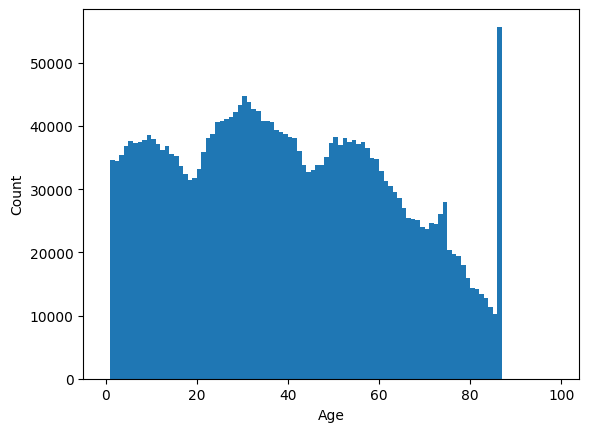

In [7]:
# Plot Age
plt.hist(
    spc.people.unnest("demographics").select("age_years"), bins=np.arange(0, 100, 1)
)
plt.gca().set(xlabel="Age", ylabel="Count")
plt.show()

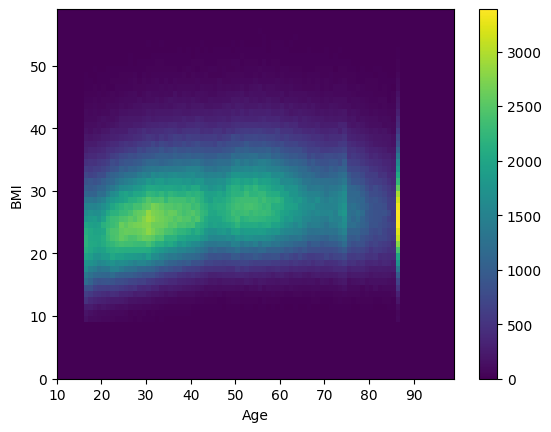

In [8]:
# Plot 2D hist of Age and BMI
age_bmi = (
    spc.people.unnest("demographics")
    .unnest("health")
    .select(["age_years", "bmi"])
    .filter(pl.col("bmi") != None)
    .to_numpy()
)
plt.hist2d(age_bmi[:, 0], age_bmi[:, 1], bins=[np.arange(10, 100), np.arange(0, 60)])
plt.gca().set(xlabel="Age", ylabel="BMI")
plt.colorbar()
plt.show()

##### Combine with weekday diaries

Are weekday activities related to health features?


In [9]:
def merge_people_and_time_use_diaries(
    spc: SPCReader, health_features, demographic_features, diary_type="weekday_diaries"
):
    # Maintain list of health features and demographic features
    people = (
        spc.people.unnest("health")
        .unnest("demographics")
        .select(
            ["id", "household"] + health_features + demographic_features + [diary_type]
        )
        .explode(diary_type)
    )
    time_use_diaries_with_idx = pl.concat(
        [
            spc.time_use_diaries,
            pl.int_range(0, spc.time_use_diaries.shape[0], eager=True)
            .rename("index")
            .cast(pl.UInt64)
            .to_frame(),
        ],
        how="horizontal",
    )
    return people.join(time_use_diaries_with_idx, left_on=diary_type, right_on="index")

##### Pick some features to explore, merge and aggregate

In [10]:
health = ["bmi"]
demographics = ["age_years"]

# Merge and aggregate
merged = merge_people_and_time_use_diaries(
    spc, ["bmi"], demographics, "weekday_diaries"
)
# List of activities
activities = merged.select(
    cs.starts_with("pm") | cs.matches("pleisure")
).columns
# Mean per person
merged_agg = (
    merged.select(["id"] + activities + health + demographics)
    .groupby(["id"], maintain_order=True)
    .mean()
)

##### Activity and Age

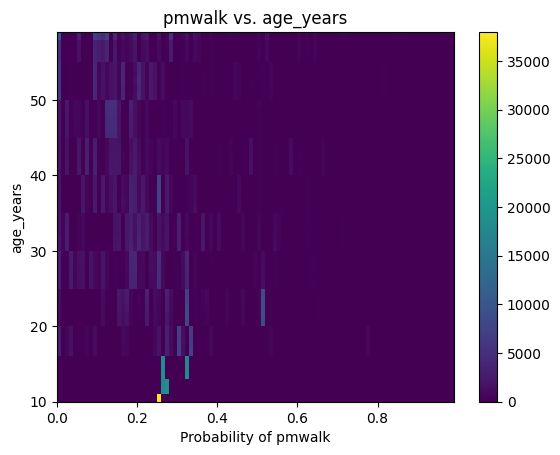

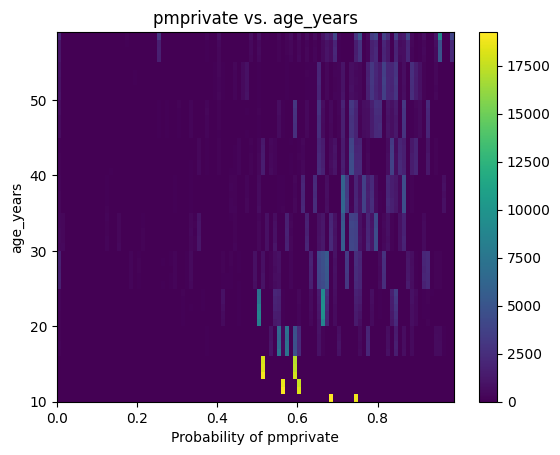

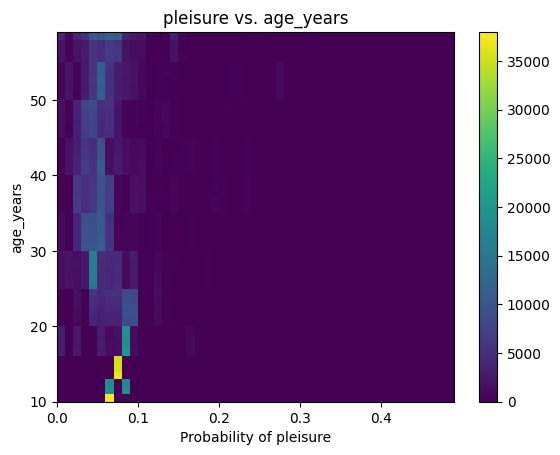

In [11]:
feature = demographics[0]
q = 0.00
for activity in ["pmwalk", "pmprivate", "pleisure"]:
    data = merged_agg.select([activity, feature]).filter(pl.col(feature) != None).to_numpy()
    plt.hist2d(data[:, 0], data[:, 1], bins=[np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1-q), 0.01), np.arange(10, 60)])
    plt.colorbar()
    plt.gca().set(title=f"{activity} vs. {feature}", xlabel=f"Probability of {activity}", ylabel=f"{feature}")
    plt.show()


#### Activity and BMI

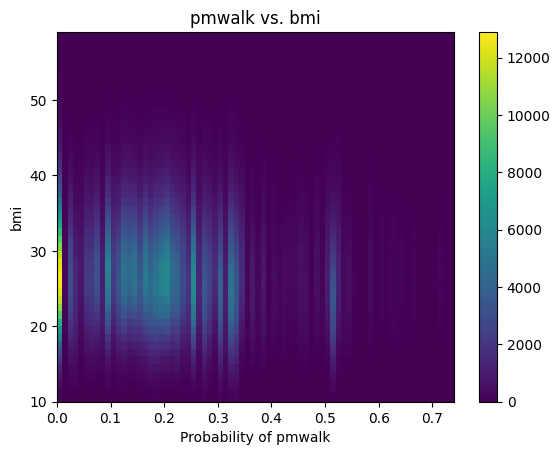

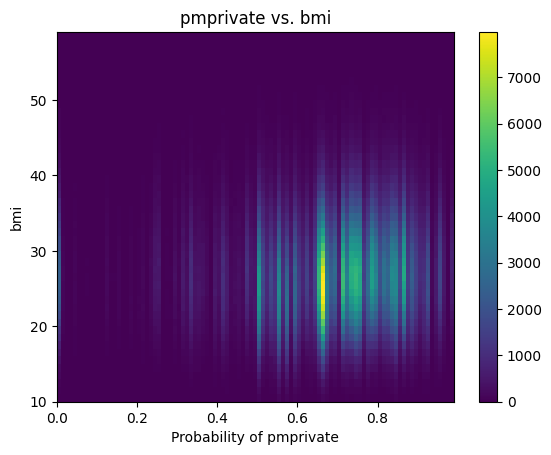

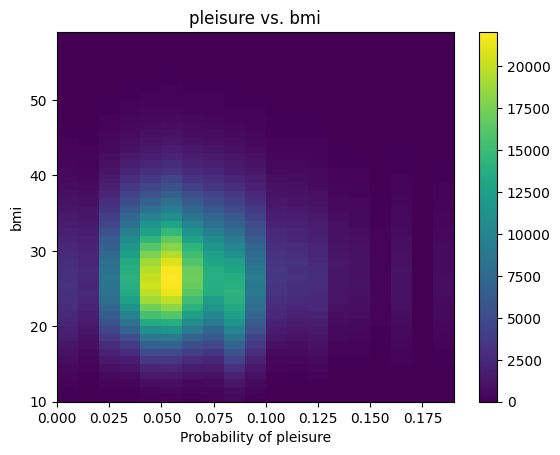

In [12]:

feature = health[0]
q = 0.01
for activity in ["pmwalk", "pmprivate", "pleisure"]:
    data = merged_agg.select([activity, feature]).filter(pl.col(feature) != None).to_numpy()
    plt.hist2d(data[:, 0], data[:, 1], bins=[np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1-q), 0.01), np.arange(10, 60)])
    plt.colorbar()
    plt.gca().set(title=f"{activity} vs. {feature}", xlabel=f"Probability of {activity}", ylabel=f"{feature}")
    plt.show()